In [2]:
import sys
sys.path.append('../bayesopt')

import read_agg_data
import torch
import torch.nn as nn
import torch.autograd as auto
import torch.optim as optim

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import math

import pdb

dvfs_dict = {
    "0xc00" :  1.2,
    "0xd00" :  1.3,
    "0xe00" :  1.4,
    "0xf00" :  1.5,
    "0x1000" : 1.6,
    "0x1100" : 1.7,
    "0x1200" : 1.8,
    "0x1300" : 1.9,
    "0x1400" : 2.0,
    "0x1500" : 2.1,
    "0x1600" : 2.2,
    "0x1700" : 2.3,
    "0x1800" : 2.4,
    "0x1900" : 2.5,
    "0x1a00" : 2.6,
    "0x1b00" : 2.7,
    "0x1c00" : 2.8,
    "0x1d00" : 2.9,
    "0xffff" : 3.0,
}

In [3]:
#df_comb, _, _ = read_agg_data.start_analysis('mcd') #DATA
#df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: int(x, base=16))

df_comb = pd.read_csv('/home/handong/jupyter/jupyter-notebooks/nic-tuning-experiments/bayesopt/summary_data/mcd_combined.csv', sep=' ')
print(df_comb.shape[0])
df_comb['QPS'] = df_comb['target_QPS']

print(df_comb['QPS'].unique())
df_comb = df_comb[(df_comb['i'] == 1) & (df_comb['rapl'] == 135)]
#df_comb = df_comb[(df_comb['rapl'] == 135)]
df_comb = df_comb[df_comb['read_99th'] <= 500]

df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: dvfs_dict[x])
df_comb = df_comb[(df_comb['itr']!=1) & (df_comb['dvfs']!=65535)] #filter out linux dynamic
print(df_comb.columns)

# df_comb['dvfs'] = df_comb['dvfs'].astype(float) / df_comb['dvfs'].min()
# print(df_comb['dvfs'].unique())
# df_comb['itr'] = df_comb['itr'].astype(float) / df_comb['itr'].min()
# print(df_comb['itr'].unique())
#print(10**6)
print(df_comb['QPS'].unique())

3073
[200000 400000 600000      0]
Index(['sys', 'i', 'itr', 'dvfs', 'rapl', 'read_5th', 'read_10th', 'read_50th',
       'read_90th', 'read_95th', 'read_99th', 'measure_QPS', 'target_QPS',
       'time', 'joules', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes',
       'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'c1', 'c1e', 'c3',
       'c6', 'c7', 'num_interrupts', 'QPS'],
      dtype='object')
[400000 600000 200000]


[ 50 100 200 300 400 350]
1675.5
******* ebbrt_tuned 50 200000
     joules_per_interrupt  itr  dvfs  num_interrupts    ref_cycles  read_99th
174              0.000209   50   1.7         5221529  1.899239e+11      103.8
262              0.000223   50   1.9         5221089  1.844129e+11      103.4
351              0.000240   50   2.1         5220371  1.796836e+11      103.3
440              0.000258   50   2.3         5214101  1.763346e+11      103.9
526              0.000277   50   2.5         5220459  1.737004e+11      103.8
616              0.000296   50   2.7         5223052  1.701433e+11      103.0
706              0.000321   50   2.9         5216163  1.690650e+11      102.8

1836.46
******* ebbrt_tuned 50 400000
     joules_per_interrupt  itr  dvfs  num_interrupts    ref_cycles  read_99th
4                0.000168   50   1.3         6036916  3.025599e+11      104.1
92               0.000180   50   1.5         6035703  2.803556e+11      104.9
179              0.000194   50   1.7    

     joules_per_interrupt  itr  dvfs  num_interrupts    ref_cycles  read_99th
39               0.000635  200   1.3         1562466  2.697584e+11      249.7
126              0.000673  200   1.5         1562481  2.621141e+11      262.6
214              0.000726  200   1.7         1562444  2.439520e+11      248.8
304              0.000757  200   1.9         1562470  2.284070e+11      250.3
392              0.000801  200   2.1         1562464  2.331850e+11      257.3
479              0.000853  200   2.3         1562467  2.306333e+11      262.2
568              0.000916  200   2.5         1562460  2.317443e+11      255.8
658              0.001002  200   2.7         1562459  2.183752e+11      249.9
748              0.001074  200   2.9         1562468  2.143033e+11      248.7

1962.71
******* ebbrt_tuned 200 600000
     joules_per_interrupt  itr  dvfs  num_interrupts    ref_cycles  read_99th
45               0.000664  200   1.3         1562473  3.654273e+11      274.8
132              0.00070

      joules_per_interrupt  itr  dvfs  num_interrupts    ref_cycles  read_99th
2203              0.001780  350   1.9          893015  5.455264e+11      491.1
2275              0.001926  350   2.1          893030  5.028107e+11      481.3
2379              0.002068  350   2.3          893027  4.667815e+11      471.4
2467              0.002237  350   2.5          893023  4.478798e+11      469.7
2555              0.002428  350   2.7          893039  4.174783e+11      457.4
2643              0.002644  350   2.9          893024  4.042622e+11      447.9

1675.5
******* ebbrt_tuned 400 200000
     joules_per_interrupt  itr  dvfs  num_interrupts    ref_cycles  read_99th
69               0.001201  400   1.3          781239  1.599319e+11      443.6
156              0.001265  400   1.5          781235  1.412006e+11      444.4
244              0.001342  400   1.7          781243  1.463764e+11      443.6
333              0.001420  400   1.9          781241  1.442308e+11      444.2
422              0

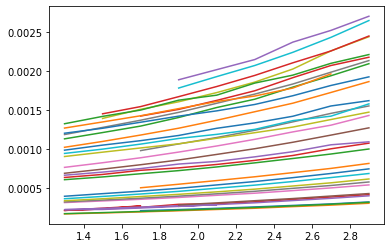

In [4]:
print(df_comb['itr'].unique())
for itr in [50, 100, 200, 300, 350, 400]:
    for sys in ['ebbrt_tuned', 'linux_tuned']:
        for qps in [200000, 400000, 600000]:
            df = df_comb[(df_comb['sys']==sys) & (df_comb['QPS'] == qps)].copy()
            #print(df.shape[0])
            print(df['joules'].max())
            df['joules_per_interrupt'] = df['joules']/df['num_interrupts']
            df = df[['joules_per_interrupt','itr', 'dvfs', 'num_interrupts', 'ref_cycles', 'read_99th']]
            #print(df.shape[0])
            #print('')
            
            dfi = df[df['itr']==itr]
            #dfi = dfi.drop_duplicates(subset = ["itr", "dvfs"])
            #dfi['joules_mean'] = dfi['joules_mean']/dfi['joules_mean'].max()
            #print(dfi.diff())
            print('*******', sys, itr, qps)
            print(dfi.sort_values(by=['dvfs']))
            #print(dfi.sort_values(by=['dvfs']).diff())
            print('')
            plt.plot(dfi['dvfs'], dfi['joules_per_interrupt'])
            #print(dfi)

In [14]:
def inference(d, n_iter, lr, workload, sys, print_freq=10):
    # p_busy_min = 20
    p_static = {
        'c1':1.5, 
        'c3':0.5,
        'c4':0.25,
        'c7':34, # 34 Watts
        'busy': 10
    }
    chosen_sleep = 'c7'

    p_q = p_static[chosen_sleep]/10**6 # joules/us idle
    # p_detect = p_static[chosen_sleep]

    #starts randomly
    zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
    alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    gamma = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    delta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    
    #p_static_busy = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    #p_detect = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    #p_q = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    #p_busy_min = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    phi = torch.tensor(torch.Tensor(1,1).uniform_(0.98, 1.0), requires_grad=True)
    
    #AA = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    #BB = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    
    
    #df[['joules','itr', 'dvfs', 'QPS', read_99th, 'num_interrupts']]
    qps = d[:,3]
    ninterrupts = d[:,5]
    energy = (d[:,0]/ninterrupts).log() ## joules/num_interrupts
    #energy = (d[:,0]/(qps).log()
    itr = d[:,1]
    dvfs = d[:,2]
    time = d[:,4]
     
    #interarrival_time = (1/qps)*10**6

    current_loss_time = -100
    fixed_zeta = -100
    fixed_alpha = -100
    fixed_phi = -100
        
    criterion = nn.MSELoss()
    optimizer_time = optim.Adam([zeta, alpha, phi], lr=lr)
    optimizer_energy = optim.Adam([gamma, beta], lr=lr)
    # optimizer = optim.Adam([max_time, alpha, beta, p_detect, p_q], lr=lr)

    for i in range(n_iter):        
        t_busy = (zeta / dvfs**(1+alpha)) ## as dvfs increases, max_time should get smaller
        pred_time = (phi*itr) + t_busy ## itr_suppress reflects where pkt is in queue
        
        loss_time = criterion(pred_time/time, torch.ones((1,pred_time.shape[1])).double())
        if i % 1000 == 0:
            print(f'MSE_loss_time={loss_time.item()} loss_time={round(math.sqrt(loss_time.item()), 5)} us'
            +f' zeta={zeta.item()} alpha={alpha.item()} phi={phi.item()}')
            
        optimizer_time.zero_grad()
        loss_time.backward(retain_graph=True)
        optimizer_time.step()

        if(current_loss_time == -100):
            current_loss_time = loss_time.item()
        else:
            if(current_loss_time >= loss_time.item()):
                current_loss_time = loss_time.item()
                fixed_zeta = zeta.item()
                fixed_alpha = alpha.item()
                fixed_phi = phi.item()
            
    for i in range(n_iter):
        #p_busy = (p_q*dvfs**(2+beta))
        #t_busy_energy = (max_time / dvfs**(1+beta))
        #t_q_energy = itr#(fixed_itr_suppress*itr)
        #t_q_energy = (interarrival_time - (fixed_itr_suppress*itr) - t_busy_energy)
        
        #pred_energy = (p_q * t_q_energy) + (p_busy * t_busy_energy)
        #pred_energy = AA*(fixed_itr_suppress*itr)**gamma + BB*dvfs**beta
        #loss_energy = criterion(pred_energy/energy, torch.ones((1,pred_energy.shape[1])).double())
        #pred_energy =  ((fixed_itr_suppress*itr*p_q)*((20*(10**6))/(fixed_itr_suppress*itr))) + (dvfs*beta)
        
        ## sigmetrics'22 equations
        pred_energy = (gamma*(fixed_itr_suppress*itr))*(dvfs**beta) #+ (AA*(dvfs**beta))
        #pred_energy = gamma+(np.log(fixed_phi)+np.log(itr))+(beta*np.log(dvfs))
        
        
        #pred_energy = (*itr + t_busy_energy)*p_q
        loss_energy = criterion(pred_energy, energy)

        if i % 1000 == 0:
            print(f'loss_energy={loss_energy.item()} loss_energy={math.sqrt(loss_energy.item())}J gamma={gamma.item()} beta={beta.item()}')
            #print(pred_energy)
            
        optimizer_energy.zero_grad()
        loss_energy.backward(retain_graph=True)
        optimizer_energy.step()
    
    return pred_energy, pred_time

In [15]:
def run_energy(df_comb, n_iter=2000, lr=1, rqps=400000, rtail='99', msys=['ebbrt_tuned'], mpred=['energy', 'time']):       
    df_comb = df_comb[df_comb['QPS'] == rqps]

    i=1
    
    for sys in msys:
        df = df_comb[(df_comb['sys']==sys)].copy()
        rt = 'read_'+rtail+'th'
        df = df[['joules','itr', 'dvfs', 'QPS', rt, 'num_interrupts']]
        tnum = df.shape[0]
        d = df.values
        d = torch.tensor(d)
        print('SYS', sys)
        #pred_energy, max_time, alpha, beta, p_detect, p_q = inference_energy(d, n_iter, lr, 'mcd', sys, print_freq=1000)
        pred_energy, pred_time = inference(d, n_iter, lr, 'mcd', sys, print_freq=1000)
        
        df[f'pre_energy lr={lr}'] = pred_energy.view(tnum, 1).detach().numpy()
        df[f'pre_time lr={lr}'] = pred_time.view(tnum, 1).detach().numpy()
                
        for pred_name in mpred:
            if pred_name == 'energy':
                pred = pred_energy
                qps = d[:,3]
                yvalue = (d[:,0]/d[:,5]).log()
                #yvalue = (d[:,0]/(qps*20)).log()
            else:
                pred = pred_time
                yvalue = d[:,4]

            #fig, ax = plt.subplots()
            ax = plt.subplot(1, len(msys)*len(mpred), i)
            
            if sys == 'ebbrt_tuned':
                plt.title(f'EbbRT @ {int(rqps/1000)}K QPS', fontsize=20)
            else:
                plt.title(f'Linux @ {int(rqps/1000)}K QPS', fontsize=20)
                
            #plt.title(f'pred:{pred_name} mcd sys={sys} lr={lr} tail={rtail} \n QPS={rqps} max_time={round(max_time,2)} \n alpha={round(alpha,2)} beta={round(beta.item(),2)} \n p_detect={round(p_detect.item(),2)}')
            if pred_name == 'energy':
                plt.ylabel('Measured Energy (J)', fontsize=20)
                plt.xlabel('Predicted Energy (J)', fontsize=20)
            else:
                plt.ylabel('Measured 99% Tail (us)', fontsize=20)
                plt.xlabel('Predicted 99% Tail (us)', fontsize=20)
            
            if pred_name == "time":
                tmax = yvalue.max().item()
                plt.plot(np.linspace(0, tmax, 10), np.linspace(0, tmax, 10))
            else:
                tmax = yvalue.max().item()
                tmin = yvalue.min().item()
                #print(yvalue.min(), yvalue.max(), tmin, tmax)
                plt.plot(np.linspace(tmin, tmax, 10), np.linspace(tmin, tmax, 10))
                
            print('measurement', yvalue.mean(), yvalue.std())
            
            scatter = ax.scatter(pred.detach().numpy()[0], yvalue, marker = 'o', 
                                 s = d[:,1], c = d[:,2], alpha=0.5)
            
            
            legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="dvfs")
            ax.add_artist(legend1)
            handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
            legend2 = plt.legend(handles, labels, loc="lower right", title="itr")
            ax.add_artist(legend2)
            
            plt.grid(True)
            plt.tight_layout()
            i += 1
    
    plt.subplots_adjust(wspace=0.3, hspace=0)
    

SYS ebbrt_tuned
MSE_loss_time=0.13425779217896575 loss_time=0.36641 us zeta=116.5868148803711 alpha=-1.045999526977539 phi=0.9871797561645508


<ipython-input-14-d9c0f58c42d9>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-14-d9c0f58c42d9>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-14-d9c0f58c42d9>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-14-d9c0f58c42d9>:19: UserWarning: To copy construct fro

MSE_loss_time=9.505161263447323e-05 loss_time=0.00975 us zeta=55.9122428894043 alpha=-0.9653685092926025 phi=0.984230637550354
MSE_loss_time=0.00015566544681643523 loss_time=0.01248 us zeta=55.56001663208008 alpha=-0.9766871929168701 phi=0.9937692880630493
MSE_loss_time=9.505173076071447e-05 loss_time=0.00975 us zeta=55.90427017211914 alpha=-0.9655163884162903 phi=0.9842406511306763
MSE_loss_time=9.505216939477982e-05 loss_time=0.00975 us zeta=55.89499282836914 alpha=-0.9656915068626404 phi=0.9842521548271179


/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([1, 43])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=263436.71921560145 loss_energy=513.2608685801027J gamma=-1.7898986339569092 beta=0.21935462951660156
loss_energy=44.99864215353025 loss_energy=6.708102723835574J gamma=-0.271661639213562 beta=-8.063189506530762
loss_energy=44.84745570318395 loss_energy=6.696824299859147J gamma=-0.26285380125045776 beta=-7.912354469299316
loss_energy=44.53619207322615 loss_energy=6.673544191299413J gamma=-0.24681691825389862 beta=-7.622581958770752
loss_energy=43.84220516879002 loss_energy=6.621344664702934J gamma=-0.21872185170650482 beta=-7.059972763061523
measurement tensor(-7.2562, dtype=torch.float64) tensor(0.6583, dtype=torch.float64)
measurement tensor(268.5023, dtype=torch.float64) tensor(125.2022, dtype=torch.float64)
SYS linux_tuned
MSE_loss_time=0.032600524740982025 loss_time=0.18056 us zeta=32.45799255371094 alpha=-1.308335781097412 phi=0.9925207495689392


<ipython-input-14-d9c0f58c42d9>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-14-d9c0f58c42d9>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-14-d9c0f58c42d9>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-14-d9c0f58c42d9>:19: UserWarning: To copy construct fro

MSE_loss_time=0.0007445113864997696 loss_time=0.02729 us zeta=86.45873260498047 alpha=-0.47653451561927795 phi=1.0952074527740479
MSE_loss_time=0.00822561802973988 loss_time=0.0907 us zeta=86.74727630615234 alpha=-0.5331271290779114 phi=1.209136962890625
MSE_loss_time=0.006746352995719148 loss_time=0.08214 us zeta=86.62887573242188 alpha=-0.352305144071579 phi=1.0106247663497925
MSE_loss_time=0.0007455941111247975 loss_time=0.02731 us zeta=86.7369613647461 alpha=-0.4701177477836609 phi=1.0940611362457275


/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([47])) that is different to the input size (torch.Size([1, 47])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=94186.85635050412 loss_energy=306.8987721554196J gamma=-1.427673578262329 beta=-0.21634268760681152
loss_energy=43.71175551356884 loss_energy=6.611486634151872J gamma=-0.46601569652557373 beta=-8.911333084106445
loss_energy=43.234054773989605 loss_energy=6.57526081414187J gamma=-0.41962099075317383 beta=-8.458392143249512
loss_energy=41.9864803681701 loss_energy=6.479697552214154J gamma=-0.33446675539016724 beta=-7.479580402374268
loss_energy=35.96470300312656 loss_energy=5.997057862246J gamma=-0.17335185408592224 beta=-4.746431350708008
measurement tensor(-7.2106, dtype=torch.float64) tensor(0.7405, dtype=torch.float64)
measurement tensor(274.5043, dtype=torch.float64) tensor(138.1329, dtype=torch.float64)


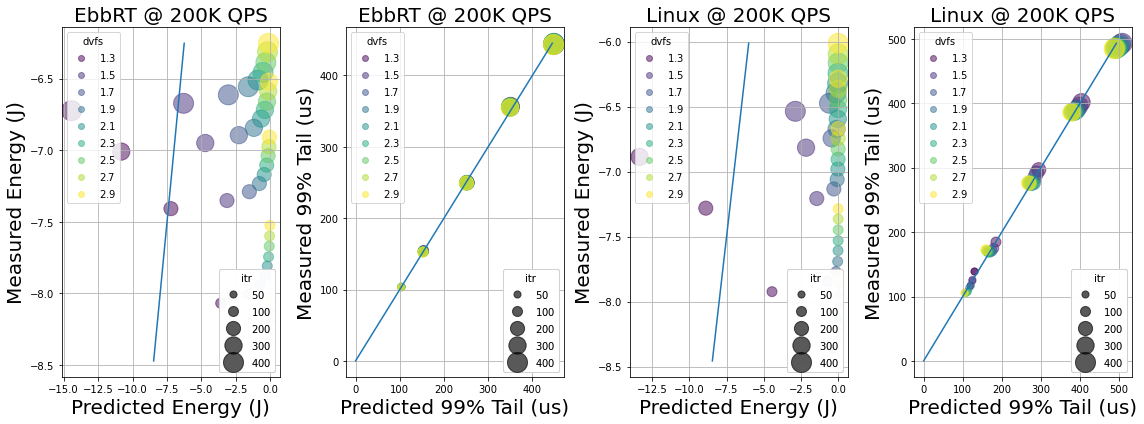

In [16]:
plt.rcParams['figure.figsize'] = 16, 6
#plt.rc('xtick', labelsize=20)    # fontsize of the tick labels    
df_comb = df_comb[df_comb['itr'] != 350]

run_energy(df_comb, n_iter=5000, lr=1, rqps=200000, rtail='99', 
           mpred=['energy', 'time'], msys=['ebbrt_tuned', 'linux_tuned'])

SYS ebbrt_tuned
MSE_loss_time=1.0751574963044432 loss_time=1.0369 us zeta=413.80426025390625 alpha=-0.21788573265075684 phi=0.8841455578804016


<ipython-input-60-f6e5860ac696>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-60-f6e5860ac696>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:19: UserWarning: To copy construct fro

MSE_loss_time=0.038697982979633 loss_time=0.19672 us zeta=378.96807861328125 alpha=7.47592830657959 phi=1.2770013809204102
MSE_loss_time=0.03816696878264051 loss_time=0.19536 us zeta=316.9184265136719 alpha=6.3361124992370605 phi=1.268079400062561
MSE_loss_time=0.00023605369523754943 loss_time=0.01536 us zeta=55.734619140625 alpha=-1.0079970359802246 phi=0.9902999401092529
MSE_loss_time=0.00023152580411718788 loss_time=0.01522 us zeta=55.73063278198242 alpha=-1.0064697265625 phi=0.9878197312355042


/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([1, 43])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=202.84454080795783 loss_energy=14.242350255767404J gamma=1.0059535503387451 beta=1.212451696395874
loss_energy=0.00304647258937297 loss_energy=0.05519486017169506J gamma=-12.850198745727539 beta=0.6686517596244812
loss_energy=0.0030464725886850982 loss_energy=0.05519486016546376J gamma=-12.850196838378906 beta=0.6686493754386902
loss_energy=0.0030464725886862336 loss_energy=0.05519486016547404J gamma=-12.850196838378906 beta=0.6686493158340454
loss_energy=0.003046472588649762 loss_energy=0.055194860165143654J gamma=-12.85019588470459 beta=0.6686481833457947
tensor(-8.6917, dtype=torch.float64) tensor(-6.2347, dtype=torch.float64) -8.691686489487775 -6.234726301565292
measurement tensor(-7.2955, dtype=torch.float64) tensor(0.7313, dtype=torch.float64)
measurement tensor(261.6047, dtype=torch.float64) tensor(125.9583, dtype=torch.float64)
SYS linux_tuned
MSE_loss_time=0.32259637871983476 loss_time=0.56798 us zeta=217.72923278808594 alpha=-1.0713615417480469 phi=0.355999946594

<ipython-input-60-f6e5860ac696>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-60-f6e5860ac696>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:19: UserWarning: To copy construct fro

MSE_loss_time=0.006343832419319423 loss_time=0.07965 us zeta=238.4120330810547 alpha=0.6271592378616333 phi=1.091758370399475
MSE_loss_time=0.0063402900170654595 loss_time=0.07963 us zeta=242.07852172851562 alpha=0.6487679481506348 phi=1.0916109085083008
MSE_loss_time=0.006340295237530636 loss_time=0.07963 us zeta=242.26953125 alpha=0.6498933434486389 phi=1.0915906429290771
MSE_loss_time=0.006380852729538191 loss_time=0.07988 us zeta=242.63905334472656 alpha=0.6554573774337769 phi=1.0824739933013916


/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([1, 43])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=114.83496568845936 loss_energy=10.716107767676627J gamma=-0.4586305618286133 beta=-1.4429817199707031
loss_energy=0.0034002285157215353 loss_energy=0.05831147842167557J gamma=-12.767843246459961 beta=0.7585389018058777
loss_energy=0.0034002285154433585 loss_energy=0.058311478419290304J gamma=-12.767845153808594 beta=0.7585412263870239
loss_energy=0.0034002285154433585 loss_energy=0.058311478419290304J gamma=-12.767845153808594 beta=0.7585412263870239
loss_energy=0.0034002285154433585 loss_energy=0.058311478419290304J gamma=-12.767845153808594 beta=0.7585412263870239
tensor(-8.4089, dtype=torch.float64) tensor(-5.9149, dtype=torch.float64) -8.408920793611529 -5.914861763269418
measurement tensor(-7.1624, dtype=torch.float64) tensor(0.7628, dtype=torch.float64)
measurement tensor(283.1814, dtype=torch.float64) tensor(129.9831, dtype=torch.float64)


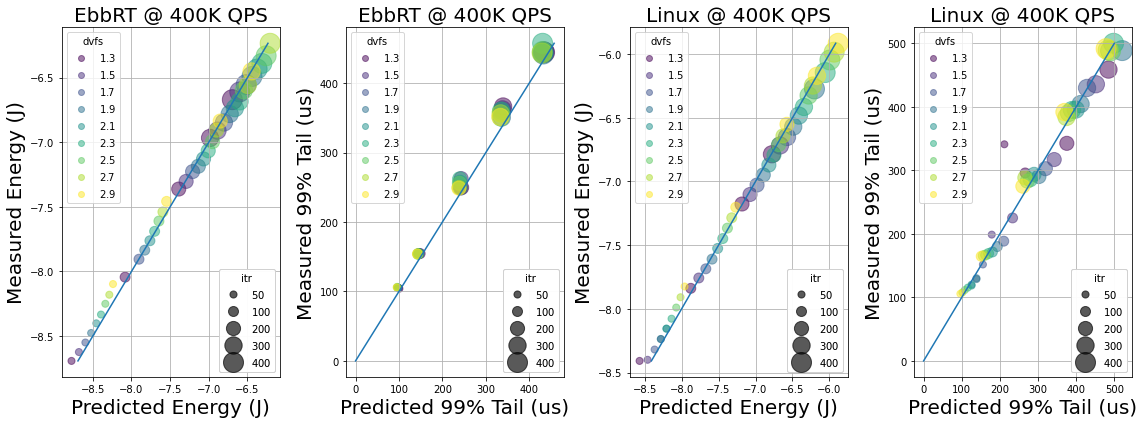

In [82]:
run_energy(df_comb, n_iter=5000, lr=1, rqps=400000, rtail='99', 
           mpred=['energy', 'time'], msys=['ebbrt_tuned', 'linux_tuned'])

SYS ebbrt_tuned
MSE_loss_time=0.17272639873153672 loss_time=0.4156 us zeta=249.36131286621094 alpha=0.16319942474365234 phi=0.28351062536239624


<ipython-input-60-f6e5860ac696>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-60-f6e5860ac696>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:19: UserWarning: To copy construct fro

MSE_loss_time=0.0006018540708879737 loss_time=0.02453 us zeta=52.222633361816406 alpha=-1.0374584197998047 phi=1.0343842506408691
MSE_loss_time=0.0006010455509550724 loss_time=0.02452 us zeta=51.72865295410156 alpha=-1.0478835105895996 phi=1.0350453853607178
MSE_loss_time=0.0006349301062736475 loss_time=0.0252 us zeta=51.689640045166016 alpha=-1.0512018203735352 phi=1.04254150390625
MSE_loss_time=0.0006010455733388009 loss_time=0.02452 us zeta=51.728668212890625 alpha=-1.0478899478912354 phi=1.035050630569458
MSE_loss_time=0.00569797683705437 loss_time=0.07548 us zeta=51.591453552246094 alpha=-1.0982624292373657 phi=1.1221656799316406
MSE_loss_time=0.0006012386977086421 loss_time=0.02452 us zeta=51.70746994018555 alpha=-1.0500953197479248 phi=1.035141110420227
MSE_loss_time=0.0006010455676814547 loss_time=0.02452 us zeta=51.72853469848633 alpha=-1.047888159751892 phi=1.0350511074066162
MSE_loss_time=0.000602646105768946 loss_time=0.02455 us zeta=51.686798095703125 alpha=-1.048612713813

/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([45])) that is different to the input size (torch.Size([1, 45])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=140.40116966362092 loss_energy=11.8490999516259J gamma=-0.07656121253967285 beta=-0.6371498107910156
loss_energy=0.0022611150704443046 loss_energy=0.04755118369130578J gamma=-12.857898712158203 beta=0.6829619407653809
loss_energy=0.0022611150704446403 loss_energy=0.047551183691309305J gamma=-12.857898712158203 beta=0.6829620003700256
loss_energy=0.0022611150704446403 loss_energy=0.047551183691309305J gamma=-12.857898712158203 beta=0.6829620003700256
loss_energy=0.0022611150709574046 loss_energy=0.04755118369670102J gamma=-12.85789966583252 beta=0.68296217918396
loss_energy=0.0022611150707249985 loss_energy=0.047551183694257274J gamma=-12.85789966583252 beta=0.6829624176025391
loss_energy=0.0026922616291300957 loss_energy=0.05188700828849256J gamma=-12.845952033996582 beta=0.695052444934845
loss_energy=0.0022611171988025057 loss_energy=0.04755120607095582J gamma=-12.85787296295166 beta=0.6829898357391357
loss_energy=0.0022614020232037345 loss_energy=0.04755420089964434J gamm

<ipython-input-60-f6e5860ac696>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-60-f6e5860ac696>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:19: UserWarning: To copy construct fro

MSE_loss_time=0.011878883507503232 loss_time=0.10899 us zeta=323.7709045410156 alpha=0.41723474860191345 phi=1.0539549589157104
MSE_loss_time=0.009886563153462856 loss_time=0.09943 us zeta=394.76812744140625 alpha=0.6238011717796326 phi=1.0387611389160156
MSE_loss_time=0.008362449305227391 loss_time=0.09145 us zeta=477.6034851074219 alpha=0.8293798565864563 phi=1.0268357992172241
MSE_loss_time=0.008671396778044961 loss_time=0.09312 us zeta=561.08837890625 alpha=0.9947963953018188 phi=1.0721476078033447
MSE_loss_time=0.012014343480092327 loss_time=0.10961 us zeta=635.4136352539062 alpha=1.181275486946106 phi=1.1522527933120728
MSE_loss_time=0.006772502670620497 loss_time=0.0823 us zeta=692.1300659179688 alpha=1.2539427280426025 phi=1.0140047073364258
MSE_loss_time=0.010029874649365176 loss_time=0.10015 us zeta=727.7911987304688 alpha=1.3897606134414673 phi=0.9555983543395996
MSE_loss_time=0.0067057084241711916 loss_time=0.08189 us zeta=746.5087280273438 alpha=1.3454385995864868 phi=1.01

/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([1, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=136.87393951645694 loss_energy=11.699313634417061J gamma=0.5920922756195068 beta=-1.064333438873291
loss_energy=0.0024915203426911212 loss_energy=0.04991513140011875J gamma=-12.735400199890137 beta=0.9075253009796143
loss_energy=0.0024915203419033543 loss_energy=0.04991513139222769J gamma=-12.735404014587402 beta=0.9075297117233276
loss_energy=0.0024915203419033543 loss_energy=0.04991513139222769J gamma=-12.735404014587402 beta=0.9075297117233276
loss_energy=0.0024915203419033543 loss_energy=0.04991513139222769J gamma=-12.735404014587402 beta=0.9075297117233276
loss_energy=0.002491520343418476 loss_energy=0.04991513140740467J gamma=-12.735404014587402 beta=0.9075311422348022
loss_energy=0.002491520342392886 loss_energy=0.04991513139713133J gamma=-12.735404968261719 beta=0.9075299501419067
loss_energy=0.002491520341889518 loss_energy=0.04991513139208909J gamma=-12.735404968261719 beta=0.9075308442115784
loss_energy=0.0024915203420158537 loss_energy=0.0499151313933546J gamma=

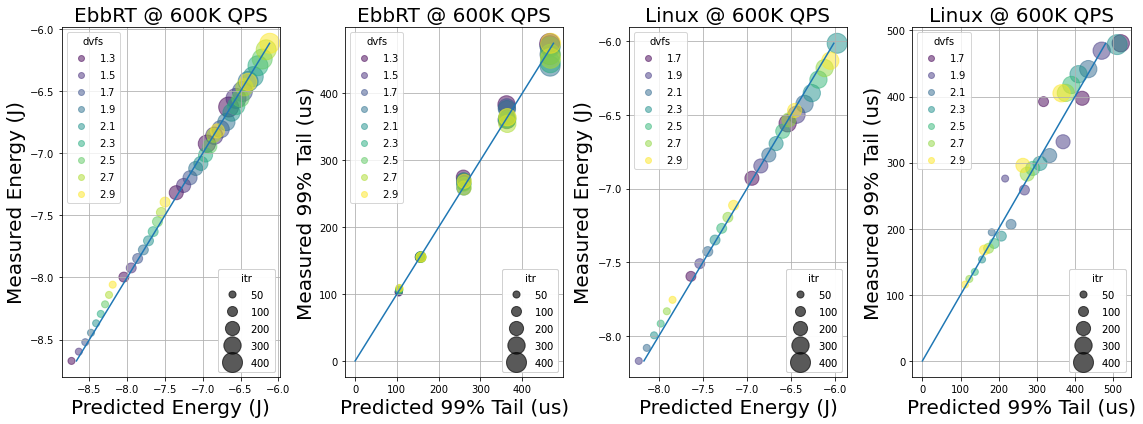

In [83]:
run_energy(df_comb, n_iter=14000, lr=1, rqps=600000, rtail='99', 
           mpred=['energy', 'time'], msys=['ebbrt_tuned', 'linux_tuned'])

SYS ebbrt_tuned
MSE_loss_time=3.466123850823403 loss_time=1.86175 us zeta=429.5527648925781 alpha=-0.9666502475738525 phi=0.6700219511985779


<ipython-input-60-f6e5860ac696>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-60-f6e5860ac696>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:19: UserWarning: To copy construct fro

MSE_loss_time=0.03406095864768174 loss_time=0.18456 us zeta=405.8588562011719 alpha=7.589137554168701 phi=1.3116512298583984
MSE_loss_time=0.03397614584678404 loss_time=0.18433 us zeta=390.543212890625 alpha=7.480998992919922 phi=1.3117531538009644
MSE_loss_time=0.03376778497923761 loss_time=0.18376 us zeta=358.89666748046875 alpha=7.001809120178223 phi=1.3084983825683594
MSE_loss_time=0.03259997937539418 loss_time=0.18055 us zeta=268.2585754394531 alpha=5.143280506134033 phi=1.2869969606399536


/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([45])) that is different to the input size (torch.Size([1, 45])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=167.2809325538804 loss_energy=12.933713022712404J gamma=1.1304125785827637 beta=-0.8106768131256104
loss_energy=0.002261115071200098 loss_energy=0.04755118369925294J gamma=-12.85789680480957 beta=0.6829594373703003
loss_energy=0.0022611150704615482 loss_energy=0.047551183691487094J gamma=-12.857898712158203 beta=0.6829618215560913
loss_energy=0.0022611150704615482 loss_energy=0.047551183691487094J gamma=-12.857898712158203 beta=0.6829618215560913
loss_energy=0.002261115070408559 loss_energy=0.047551183690929914J gamma=-12.85789966583252 beta=0.6829630136489868
measurement tensor(270.9156, dtype=torch.float64) tensor(132.8082, dtype=torch.float64)


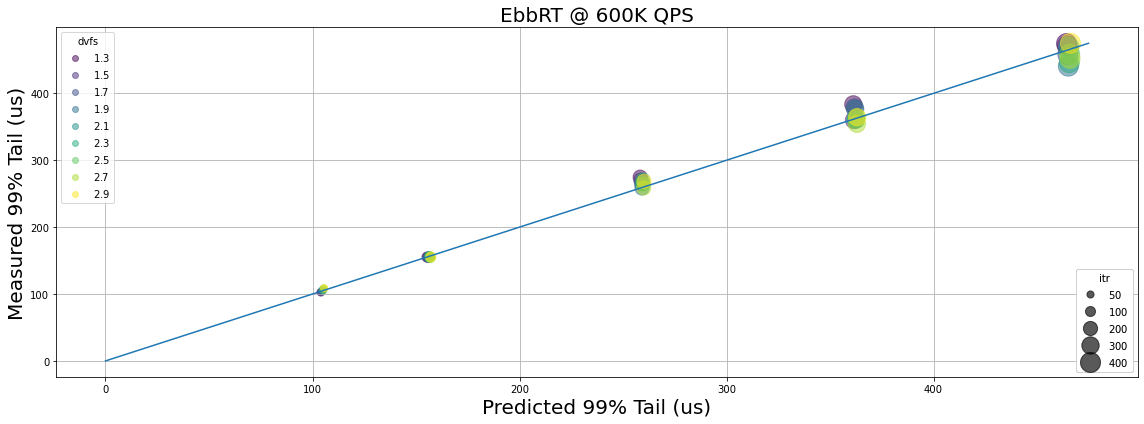

In [84]:
run_energy(df_comb, n_iter=5000, lr=1, rqps=600000, rtail='99', 
           mpred=['time'], msys=['ebbrt_tuned'])

SYS ebbrt_tuned
MSE_loss_time=0.250746345310389 loss_time=0.50075 us zeta=219.5358428955078 alpha=-0.13427114486694336 phi=0.16302889585494995


<ipython-input-60-f6e5860ac696>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-60-f6e5860ac696>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:19: UserWarning: To copy construct fro

MSE_loss_time=0.00011815393441662156 loss_time=0.01087 us zeta=40.25274658203125 alpha=-0.861304759979248 phi=0.5298420786857605
MSE_loss_time=0.00019645266694098368 loss_time=0.01402 us zeta=38.915367126464844 alpha=-0.893722653388977 phi=0.5386803150177002
MSE_loss_time=0.0004034163373217096 loss_time=0.02009 us zeta=38.81593322753906 alpha=-0.9112141132354736 phi=0.5424319505691528
MSE_loss_time=0.000111404641078033 loss_time=0.01055 us zeta=38.83777618408203 alpha=-0.8948989510536194 phi=0.5319880247116089


/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([1, 43])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=125.50113366436524 loss_energy=11.202728849006622J gamma=-1.395688772201538 beta=1.1223609447479248
loss_energy=0.007790184376058229 loss_energy=0.08826202114192848J gamma=-12.280386924743652 beta=0.6863613724708557
loss_energy=0.007790184375574674 loss_energy=0.08826202113918916J gamma=-12.280388832092285 beta=0.6863637566566467
loss_energy=0.007790184375574674 loss_energy=0.08826202113918916J gamma=-12.280388832092285 beta=0.6863637566566467
loss_energy=0.007790184375574674 loss_energy=0.08826202113918916J gamma=-12.280388832092285 beta=0.6863637566566467
SYS linux_tuned
MSE_loss_time=0.17849212517629381 loss_time=0.42248 us zeta=101.657470703125 alpha=0.49157261848449707 phi=0.2722965478897095


<ipython-input-60-f6e5860ac696>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-60-f6e5860ac696>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-60-f6e5860ac696>:19: UserWarning: To copy construct fro

MSE_loss_time=0.00034110931106035394 loss_time=0.01847 us zeta=63.819984436035156 alpha=-0.47737956047058105 phi=0.6017702221870422
MSE_loss_time=0.0003411219797596367 loss_time=0.01847 us zeta=63.81975173950195 alpha=-0.47725775837898254 phi=0.6016944646835327
MSE_loss_time=0.0006163266914316118 loss_time=0.02483 us zeta=63.96173858642578 alpha=-0.5066607594490051 phi=0.6098025441169739
MSE_loss_time=0.00034111043485742995 loss_time=0.01847 us zeta=63.82070541381836 alpha=-0.4773516058921814 phi=0.6017425656318665


/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([47])) that is different to the input size (torch.Size([1, 47])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=133.2286513545547 loss_energy=11.542471631091614J gamma=0.9536914825439453 beta=-1.6257336139678955
loss_energy=0.013456890477387242 loss_energy=0.11600383820110109J gamma=-12.209689140319824 beta=0.7141976952552795
loss_energy=0.013456890477387799 loss_energy=0.11600383820110349J gamma=-12.209689140319824 beta=0.7141976356506348
loss_energy=0.013456890477333285 loss_energy=0.11600383820086853J gamma=-12.20969009399414 beta=0.7141988277435303
loss_energy=0.013456890477332117 loss_energy=0.1160038382008635J gamma=-12.20969009399414 beta=0.714198887348175


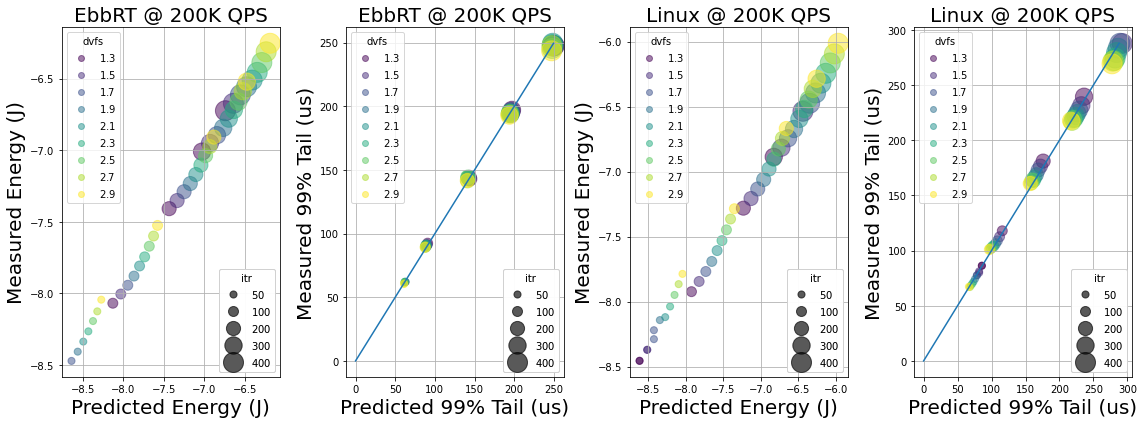

In [68]:
run_energy(df_comb, n_iter=5000, lr=1, rqps=200000, rtail='50', 
           mpred=['energy', 'time'], msys=['ebbrt_tuned', 'linux_tuned'])

In [48]:
ddf = pd.read_csv('~/github/energy_trace_experiment_scripts/collected_data/mcd_combined.csv', sep=' ')
ddf['QPS'] = ddf['target_QPS']
ddf = ddf[ddf['rapl'] == 135]
ddf = ddf[ddf['read_99th'] <= 500]
ddf = ddf[ddf['i'] == 0]

ddf['dvfs'] = ddf['dvfs'].apply(lambda x: dvfs_dict[x])
ddf = ddf[(ddf['itr']!=1) & (ddf['dvfs']!=65535)] #filter out linux dynamic
print(df_comb.columns)
print(ddf['QPS'].unique())
print(ddf['i'].unique())
print(ddf.shape[0])

Index(['sys', 'i', 'itr', 'dvfs', 'rapl', 'read_5th', 'read_10th', 'read_50th',
       'read_90th', 'read_95th', 'read_99th', 'measure_QPS', 'target_QPS',
       'time', 'joules', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes',
       'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'c1', 'c1e', 'c3',
       'c6', 'c7', 'num_interrupts', 'QPS'],
      dtype='object')
[ 200000  400000  600000 1000000 1500000]
[0]
645


SYS ebbrt_tuned
loss_time=1.347581989426996 zeta=375.9709777832031 alpha=0.22811484336853027 phi=0.6536439657211304


<ipython-input-13-cf8f83d16ad3>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-13-cf8f83d16ad3>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-13-cf8f83d16ad3>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-13-cf8f83d16ad3>:19: UserWarning: To copy construct fro

loss_time=0.015020846242065705 zeta=69.32869720458984 alpha=-0.7216720581054688 phi=1.053759217262268
loss_time=0.015020846242079064 zeta=69.32869720458984 alpha=-0.7216721773147583 phi=1.0537593364715576
loss_time=0.015020986652044559 zeta=69.32296752929688 alpha=-0.7213442921638489 phi=1.053292155265808
loss_time=0.01537675617184246 zeta=69.30174255371094 alpha=-0.6992050409317017 phi=1.0310273170471191


<ipython-input-13-cf8f83d16ad3>:88: RuntimeWarning: divide by zero encountered in log
  pred_energy = gamma+(np.log(fixed_phi)+np.log(itr))+(beta*np.log(dvfs))
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([90])) that is different to the input size (torch.Size([1, 90])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=inf gamma=-0.9975230693817139 beta=0.7300441265106201
loss_energy=nan gamma=nan beta=nan
loss_energy=nan gamma=nan beta=nan
loss_energy=nan gamma=nan beta=nan
loss_energy=nan gamma=nan beta=nan


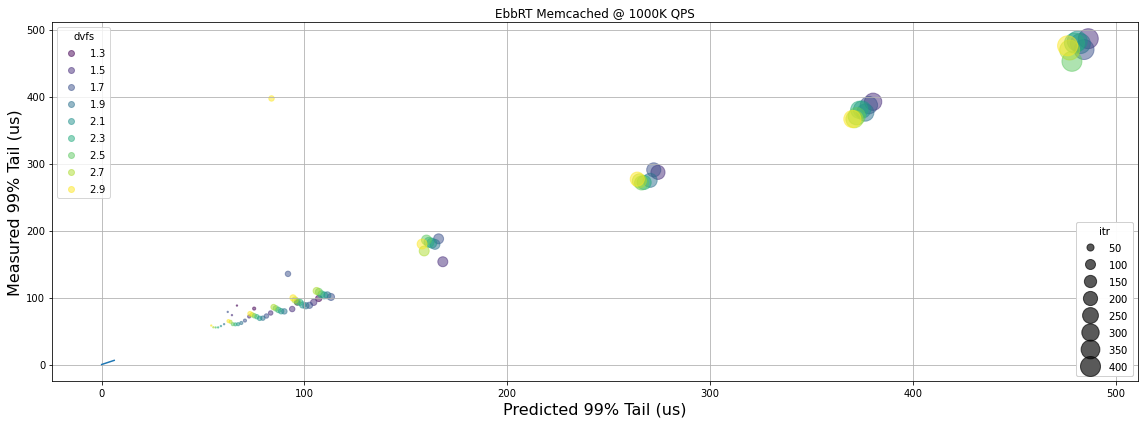

In [49]:


run_energy(ddf, n_iter=5000, lr=1, rqps=1000000, rtail='99', 
           mpred=['time'], msys=['ebbrt_tuned'])

SYS ebbrt_tuned
loss_time=0.43016901033855376 zeta=57.74052047729492 alpha=1.6297779083251953 phi=0.8215769529342651


<ipython-input-13-cf8f83d16ad3>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-13-cf8f83d16ad3>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-13-cf8f83d16ad3>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-13-cf8f83d16ad3>:19: UserWarning: To copy construct fro

loss_time=0.027117732281898586 zeta=125.97518157958984 alpha=-0.03338911011815071 phi=1.2233915328979492
loss_time=0.027117753563222227 zeta=126.15747833251953 alpha=-0.03212921321392059 phi=1.2227662801742554
loss_time=0.02775474995877512 zeta=126.0926513671875 alpha=0.00632043182849884 phi=1.198974847793579
loss_time=0.02742354888049212 zeta=126.09355926513672 alpha=-0.008886348456144333 phi=1.2021839618682861


<ipython-input-13-cf8f83d16ad3>:88: RuntimeWarning: divide by zero encountered in log
  pred_energy = gamma+(np.log(fixed_phi)+np.log(itr))+(beta*np.log(dvfs))
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([70])) that is different to the input size (torch.Size([1, 70])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=inf gamma=-0.9948389530181885 beta=1.2042922973632812
loss_energy=nan gamma=nan beta=nan
loss_energy=nan gamma=nan beta=nan
loss_energy=nan gamma=nan beta=nan
loss_energy=nan gamma=nan beta=nan


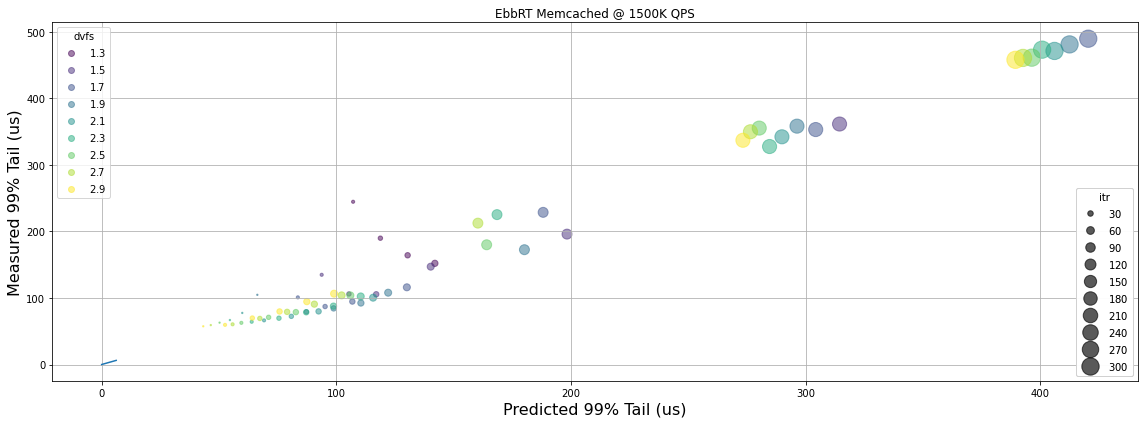

In [50]:
run_energy(ddf, n_iter=5000, lr=1, rqps=1500000, rtail='99', 
           mpred=['time'], msys=['ebbrt_tuned'])

In [49]:
def run_time(df_comb, n_iter=2000, lr=1, rqps=400000, rtail='99', msys=['ebbrt_tuned']):       
    df_comb = df_comb[df_comb['QPS'] == rqps]

    for sys in msys:
        df = df_comb[(df_comb['sys']==sys)].copy()
        rt = 'read_'+rtail+'th_mean'
        df = df[['joules_mean','itr', 'dvfs', 'QPS', rt]]
        d = df.values
        d = torch.tensor(d)
        #plt.plot(d[:,0], d[:,1], 'p')

        pred_time, max_time, alpha, itr_suppress = inference_time(d, n_iter, lr, 'mcd', sys, print_freq=1000)
        tnum = 0
        if rqps == 200000:
            if sys == 'linux_tuned':
                tnum=345
            else:
                tnum=246
        elif rqps == 400000:
            if sys == 'linux_tuned':
                tnum=318
                #df[f'pre_energy lr={lr}'] = pred_energy.view(318, 1).detach().numpy()
                #df[f'pre_time lr={lr}'] = pred_time.view(318, 1).detach().numpy()
            else:
                tnum=245
                #df[f'pre_energy lr={lr}'] = pred_energy.view(245, 1).detach().numpy()
                #df[f'pre_time lr={lr}'] = pred_time.view(245, 1).detach().numpy()
        if rqps == 600000:
            if sys == 'linux_tuned':
                tnum=202
            else:
                tnum=246
        df[f'pre_time lr={lr}'] = pred_time.view(tnum, 1).detach().numpy()

#             for pred_name in ['time', 'energy']:
#                 if pred_name == 'energy':
#                     pred = pred_energy
#                     qps = d[:,3]
#                     yvalue = d[:,0]/(qps*20)
#                 else:
        pred = pred_time
        yvalue = d[:,4]
        fig, ax = plt.subplots()
        plt.title(f'pred:time mcd sys={sys} lr={lr} tail={rtail} \n QPS={rqps} max_time={round(max_time.item(),2)} \n alpha={round(alpha.item(),2)} itr_suppress={round(itr_suppress.item(),2)}')
        plt.xlabel(u"predictions")
        plt.ylabel('time')
        scatter = ax.scatter(pred.detach().numpy()[0], yvalue, marker = 'o', s = d[:,1], c = d[:,2], alpha=0.3)
        legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="dvfs")
        ax.add_artist(legend1)
        handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
        legend2 = plt.legend(handles, labels, loc="lower right", title="itr")
        ax.add_artist(legend2)
        
run_time(df_comb, rqps=200000, rtail='90')
run_time(df_comb, rqps=400000, rtail='90')
run_time(df_comb, rqps=600000, rtail='90')

<ipython-input-7-f94ae881036c>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-7-f94ae881036c>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-7-f94ae881036c>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-7-f94ae881036c>:19: UserWarning: To copy construct fro

429.2119140625 -0.5882140398025513 -0.9464408159255981 35.02513128982781
211.00961303710938 3.6269314289093018 0.9249256253242493 0.24131148425789484


KeyboardInterrupt: 

<ipython-input-47-3514657f030e>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-47-3514657f030e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-47-3514657f030e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-47-3514657f030e>:19: UserWarning: To copy construct

AttributeError: 'float' object has no attribute 'item'

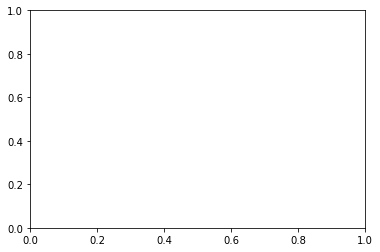